In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import random
%matplotlib inline

In [2]:
args = {'lr':0.01,
        'train epochs':1500,
        'hidden layers':5,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0,
        'input features': 40,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        'dropout':0.5
        }

now = datetime.now()

# Data Prep

In [3]:
# define layer dictionary to store per layer info
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [4]:
df = pd.read_excel('data_3nm.xlsx')

In [5]:
# spectrum data
X = df.iloc[:,11:]

# layer data
y = df.iloc[:,:11]

In [6]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [7]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [8]:
# add noise
X_noisy = add_noise(X, args['noise'])

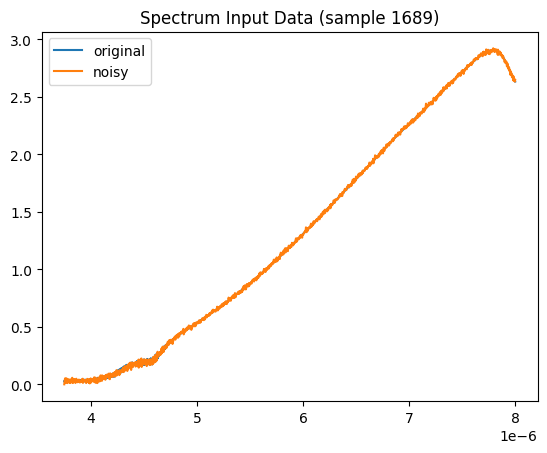

In [9]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [10]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [12]:
'''for layer in layers:
    inputs = X_train
    targets = y_train[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['input features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')

'''
# select features that correlate more than given amount
for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')#'''


Features for Layer 1 (1417):
 [3.951e-06, 3.972e-06, 3.957e-06, 3.978e-06, 3.942e-06, 3.963e-06, 3.999e-06, 3.933e-06, 3.993e-06, 3.984e-06, 3.966e-06, 3.939e-06, 3.93e-06, 3.921e-06, 4.005e-06, 3.948e-06, 3.912e-06, 3.969e-06, 3.924e-06, 3.987e-06, 3.96e-06, 3.903e-06, 3.99e-06, 3.954e-06, 3.975e-06, 4.011e-06, 3.945e-06, 3.981e-06, 3.936e-06, 3.915e-06, 3.894e-06, 3.996e-06, 3.927e-06, 4.017e-06, 3.918e-06, 4.002e-06, 3.909e-06, 3.888e-06, 4.008e-06, 3.9e-06, 4.014e-06, 3.906e-06, 4.02e-06, 4.026e-06, 3.879e-06, 4.023e-06, 4.032e-06, 4.038e-06, 3.897e-06, 3.885e-06, 4.044e-06, 4.029e-06, 3.891e-06, 3.864e-06, 3.873e-06, 4.05e-06, 3.882e-06, 3.87e-06, 4.035e-06, 3.876e-06, 4.041e-06, 3.855e-06, 4.056e-06, 3.849e-06, 3.867e-06, 4.047e-06, 3.858e-06, 3.861e-06, 3.843e-06, 4.065e-06, 4.053e-06, 4.059e-06, 4.071e-06, 3.837e-06, 4.062e-06, 3.852e-06, 3.846e-06, 3.831e-06, 3.84e-06, 4.077e-06, 4.068e-06, 3.834e-06, 3.825e-06, 3.828e-06, 4.074e-06, 3.822e-06, 4.086e-06, 4.08e-06, 3.819e-06, 

In [13]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [14]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)
        self.dropout = nn.Dropout(args['dropout'])

    def forward(self, x):

        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.dropout(x)
        x = self.lin_fin(x)
        return x

In [15]:
criterion = args['train criterion']

In [16]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    # instantiate model
    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        # forward pass
        outputs = model(input)

        # get loss
        loss = criterion(outputs, target)

        # update and backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    # store model and losses
    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [1417, 1180, 944, 708, 472, 236]
epoch: 150, loss = 17.653074264526367
epoch: 300, loss = 9.776095390319824
epoch: 450, loss = 7.089841365814209
epoch: 600, loss = 6.054040908813477
epoch: 750, loss = 5.443495750427246
epoch: 900, loss = 5.089051246643066
epoch: 1050, loss = 4.739346504211426
epoch: 1200, loss = 4.367523670196533
epoch: 1350, loss = 4.366059303283691
epoch: 1500, loss = 4.3071465492248535
best loss: 4.099670886993408 in epoch 1437

layer 2
hidden layer sizes: [1417, 1180, 944, 708, 472, 236]
epoch: 150, loss = 21.95692253112793
epoch: 300, loss = 13.384092330932617
epoch: 450, loss = 10.942902565002441
epoch: 600, loss = 9.243931770324707
epoch: 750, loss = 7.703009605407715
epoch: 900, loss = 6.939011096954346
epoch: 1050, loss = 6.526694297790527
epoch: 1200, loss = 5.979187965393066
epoch: 1350, loss = 5.732367515563965
epoch: 1500, loss = 5.590655326843262
best loss: 5.311076641082764 in epoch 1474

layer 3
hidden layer sizes: [1417, 118

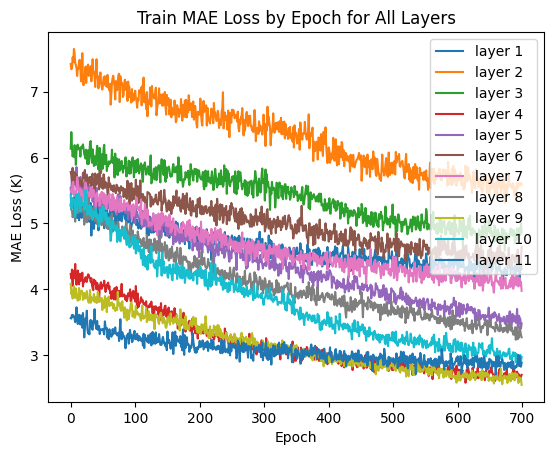

In [27]:
for layer in layers:
    plt.plot(layer['train losses'][800:], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [18]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

        layer['test pred'] = pred

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

print(f"Average: {sum(test_losses)/len(test_losses)}")

layer 1 loss: 6.034577369689941
layer 2 loss: 10.546894073486328
layer 3 loss: 6.904787540435791
layer 4 loss: 4.842942714691162
layer 5 loss: 6.0041985511779785
layer 6 loss: 7.134847640991211
layer 7 loss: 6.663394451141357
layer 8 loss: 5.003715991973877
layer 9 loss: 4.627105712890625
layer 10 loss: 3.5208144187927246
layer 11 loss: 2.9029011726379395
Average: 5.835107239809903


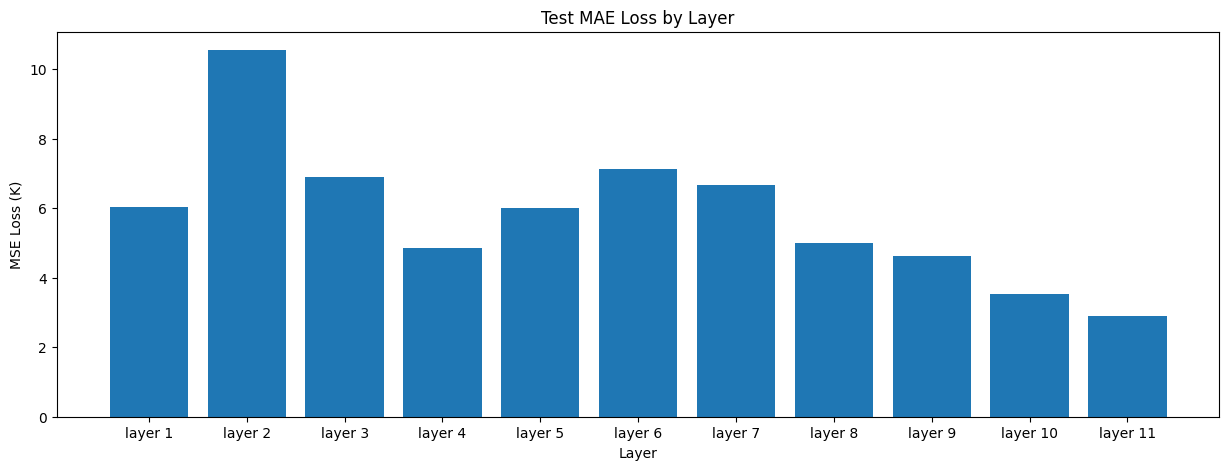

In [19]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [20]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [21]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

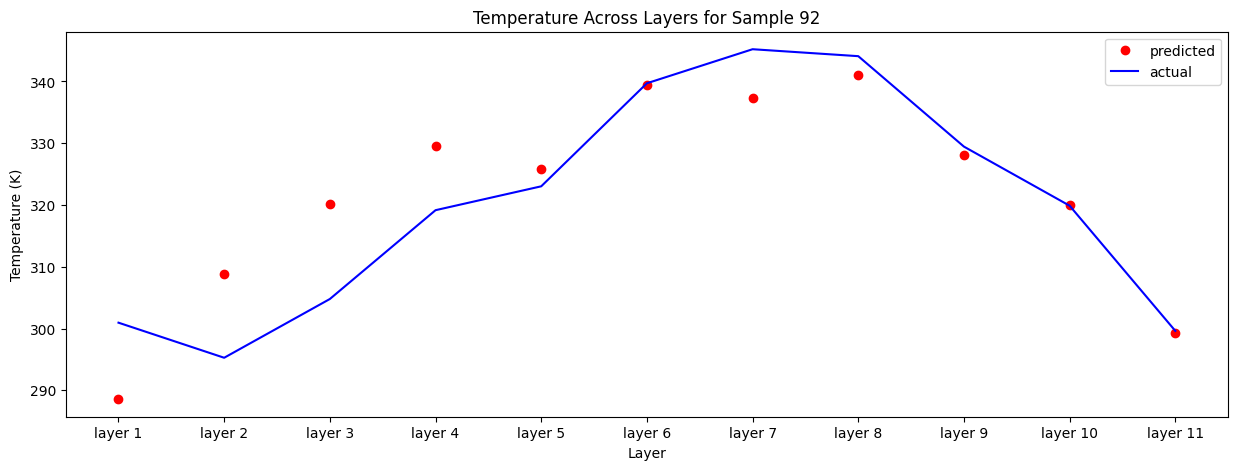

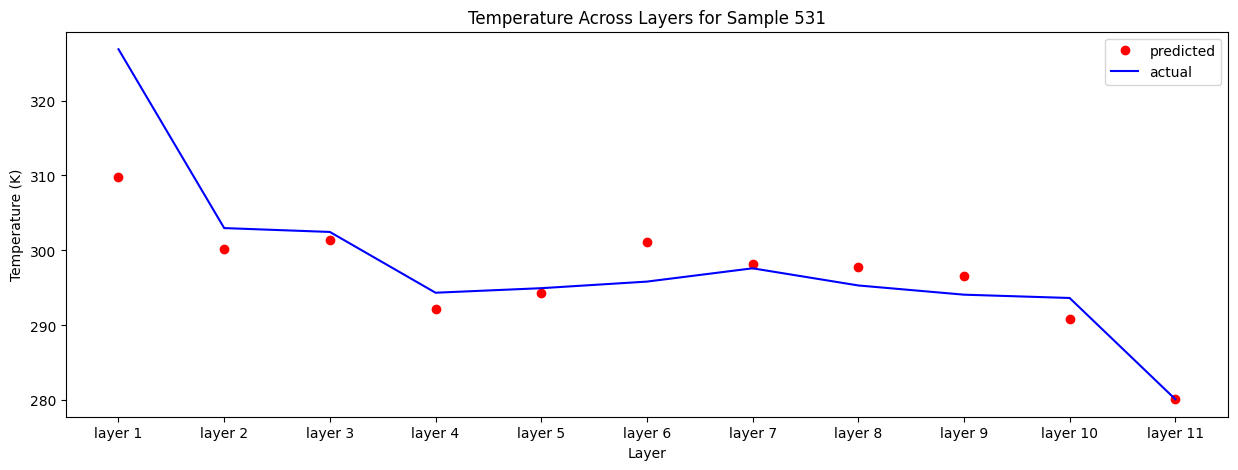

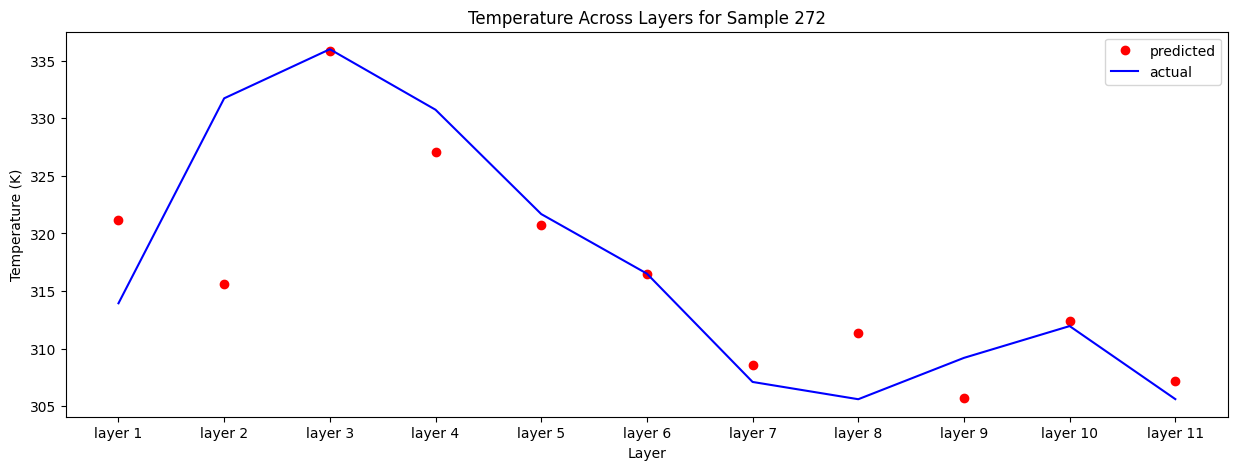

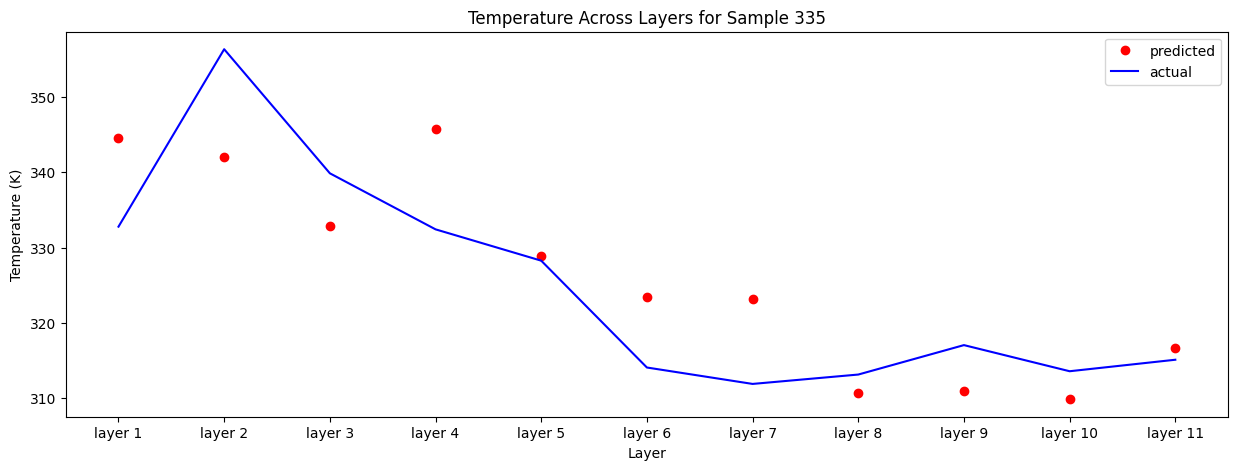

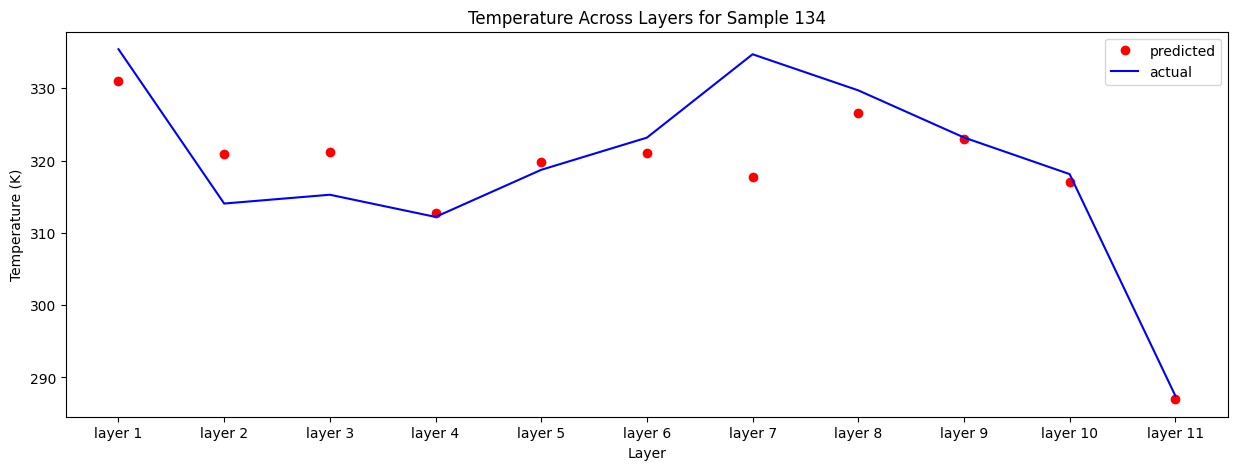

In [22]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [23]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')

In [24]:
model = layers[0]['model']
x = layers[0]['X_test']
y = model(x)